# Задание 1
Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)

2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)

3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [1]:
import re
import pandas as pd
import numpy as np
import gensim
import string
import tensorflow as tf
from collections import Counter
from pymorphy2 import MorphAnalyzer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
punctuation = string.punctuation + '—«»…'

In [2]:
wiki = open('wiki_data.txt', encoding='utf-8').read().split('\n')

In [14]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [3]:
morph = MorphAnalyzer()

In [4]:
def preprocess(text):
    tokenized = re.findall('[А-Яа-яёЁA-Za-z0-9-]+', text.lower())
    lemmatized = [morph.parse(token)[0].normal_form for token in tokenized]
    return lemmatized

In [5]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [6]:
filtered_vocab = []

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.append(word)

In [7]:
word2id = {word: order + 1 for order, word in enumerate(filtered_vocab)}

In [8]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [9]:
id2word = {i:word for word, i in word2id.items()}

In [10]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [11]:
vocab_size = len(id2word)

In [12]:
sum_occurences = sum(vocab[i] for i in filtered_vocab)

In [13]:
word_probs = [vocab[word] / sum_occurences for word in filtered_vocab]

CBOW

In [15]:
def gen_batches_cbow(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = (sent[max(0, i - window // 2):i] + 
                           sent[i + 1:i + window // 2]) 

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(word2id[np.random.choice(
                    filtered_vocab, p=word_probs)])  
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [16]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

С изменённым размером окна:

In [17]:
model.fit(gen_batches_cbow(sentences, window=6),
          validation_data=gen_batches_cbow(sentences,  window=6),
          batch_size=1000,
          steps_per_epoch=2000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
2000/2000 [==============================] - 5699s 3s/step - loss: 0.6856 - accuracy: 0.5507 - val_loss: 0.6726 - val_accuracy: 0.6033
Epoch 2/2
2000/2000 [==============================] - 41604s 21s/step - loss: 0.6521 - accuracy: 0.6255 - val_loss: 0.6358 - val_accuracy: 0.6428


In [18]:
cbow_embeddings = model.layers[2].get_weights()[0]

Skip-gram

In [19]:
def gen_batches_skip_gram(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent) - 1):
                word = sent[i]
                context = (sent[max(0, i - window // 2):i] + 
                           sent[i + 1:i + window // 2]) # окно разбивается на две половины
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(word2id[np.random.choice(
                        filtered_vocab, p=word_probs)]) # негативные примеры выбираются пропорционально вероятностям
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [20]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

sg_model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
sg_model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [21]:
sg_embeddings =  sg_model.layers[2].get_weights()[0]

Сравним:

In [24]:
most_similar('снег', cbow_embeddings)

['снег',
 'система',
 'подключение',
 'момент',
 'борьба',
 'выдвигать',
 'мультсериал',
 'бы',
 'тв',
 'кислота']

In [25]:
most_similar('снег', sg_embeddings)

['снег',
 'далее',
 'теория',
 'возвращать',
 'резня',
 'терри',
 'мэн',
 'временной',
 'март',
 'некоммерческий']

Очень странные результаты выдаёт и та, и другая модель. Skip-gram всё-таки показывает слова ближе по смыслу к исходному (март, временной)

# Задание 2

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [136]:
texts = [preprocess(text) for text in wiki]

In [137]:
import gensim

In [138]:
word2vec_model = gensim.models.Word2Vec(texts, 
                             vector_size=200, 
                             min_count=15, 
                             max_vocab_size=12000,
                             window=4,
                             epochs=10,
                             hs=1,
                             negative=0,
                             sample=1e-4,
                             ns_exponent=0,
                             cbow_mean=0)

In [139]:
fasttext_model = gensim.models.FastText(texts,
                                        vector_size=200, 
                                        min_count=15,
                                        max_vocab_size=12000, 
                                        window=4,
                                        epochs=10,
                                        hs=1,
                                        negative=0,
                                        sample=1e-4,
                                        ns_exponent=0,
                                        cbow_mean=0,
                                        min_n=4,
                                        max_n=7)

In [140]:
word2vec_model.wv.most_similar('корабль')

[('крейсер', 0.642787754535675),
 ('судно', 0.607828676700592),
 ('эскадра', 0.5978864431381226),
 ('эсминец', 0.5854548215866089),
 ('судный', 0.5616894364356995),
 ('миноносец', 0.5521610379219055),
 ('борт', 0.5320674777030945),
 ('адмирал', 0.528944730758667),
 ('флот', 0.5113173127174377),
 ('флотилия', 0.48482030630111694)]

In [141]:
fasttext_model.wv.most_similar('корабль')

[('крейсер', 0.6746718287467957),
 ('судно', 0.6535720229148865),
 ('судный', 0.6183388829231262),
 ('эскадра', 0.5689698457717896),
 ('эсминец', 0.5681909322738647),
 ('миноносец', 0.5628681182861328),
 ('борт', 0.5330899357795715),
 ('отряд', 0.5323577523231506),
 ('флот', 0.5318790674209595),
 ('ракета', 0.5141982436180115)]

In [142]:
word2vec_model.wv.most_similar('собака')

[('порода', 0.47815370559692383),
 ('животное', 0.4734041690826416),
 ('мясо', 0.42044422030448914),
 ('они', 0.40695086121559143),
 ('пища', 0.39507773518562317),
 ('пациент', 0.3897048234939575),
 ('рыба', 0.3862999379634857),
 ('свердруп', 0.38574331998825073),
 ('охота', 0.38222169876098633),
 ('опасный', 0.37021470069885254)]

In [143]:
fasttext_model.wv.most_similar('собака')

[('животное', 0.5320990085601807),
 ('порода', 0.45978838205337524),
 ('они', 0.41830188035964966),
 ('мясо', 0.4162420630455017),
 ('кость', 0.41455402970314026),
 ('свердруп', 0.41053223609924316),
 ('охота', 0.40167325735092163),
 ('пища', 0.39776405692100525),
 ('рыба', 0.39150574803352356),
 ('мальчик', 0.3842502236366272)]

Обе модели выдают качественные эмбеддинги.

# Задание 3

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [144]:
labeled = pd.read_csv('labeled.csv')

In [145]:
labeled['preprocessed'] = labeled.comment.apply(preprocess)

In [146]:
vocab = Counter()

for text in labeled['preprocessed']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6358

In [147]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [148]:
X = []

for tokens in labeled['preprocessed']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [149]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=200)
y = labeled.toxic.values

In [150]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

Word2Vec

In [151]:
weights = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights[i] = word2vec_model.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = word2vec_model.wv['опрагпллирао']

In [152]:
inputs = tf.keras.layers.Input(shape=(200,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [153]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6534 - accuracy: 0.6629 - val_loss: 0.6257 - val_accuracy: 0.6727
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6247 - accuracy: 0.6643 - val_loss: 0.6156 - val_accuracy: 0.6727
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6198 - accuracy: 0.6643 - val_loss: 0.6129 - val_accuracy: 0.6727
Epoch 4/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6174 - accuracy: 0.6643 - val_loss: 0.6112 - val_accuracy: 0.6727
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6154 - accuracy: 0.6643 - val_loss: 0.6095 - val_accuracy: 0.6727
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6134 - accuracy: 0.6643 - val_loss: 0.6080 - val_accuracy: 0.6727
Epoch 7/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6114 - accuracy: 0.6643 - val_loss: 0.6065 - val_accuracy: 0.6727
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


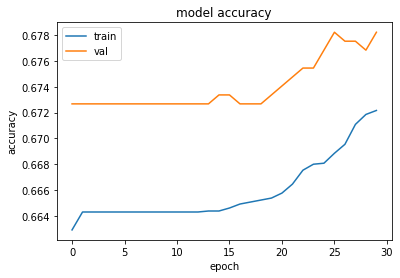

In [154]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

FastText

In [155]:
weights = np.zeros((len(word2id), 200))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights[i] = fasttext_model.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = fasttext_model.wv['опрагпллирао']

In [156]:
inputs = tf.keras.layers.Input(shape=(200,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [157]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6608 - accuracy: 0.6625 - val_loss: 0.6364 - val_accuracy: 0.6727
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6330 - accuracy: 0.6643 - val_loss: 0.6233 - val_accuracy: 0.6727
Epoch 3/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6272 - accuracy: 0.6643 - val_loss: 0.6204 - val_accuracy: 0.6727
Epoch 4/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6258 - accuracy: 0.6643 - val_loss: 0.6193 - val_accuracy: 0.6727
Epoch 5/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6250 - accuracy: 0.6643 - val_loss: 0.6188 - val_accuracy: 0.6727
Epoch 6/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6243 - accuracy: 0.6643 - val_loss: 0.6184 - val_accuracy: 0.6727
Epoch 7/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6237 - accuracy: 0.6643 - val_loss: 0.6180 - val_accuracy: 0.6727
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


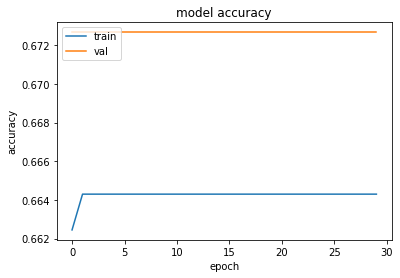

In [158]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

CBOW

In [159]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():

    if word == 'PAD':
        continue

    try:
        weights[i] = cbow_embeddings[word2id[word]]
    
    except KeyError:
        continue
        weights[i] = cbow_embeddings[word2id['опрагпллирао']]

In [160]:
inputs = tf.keras.layers.Input(shape=(200,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [161]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 3s 5ms/step - loss: 0.6692 - accuracy: 0.6640 - val_loss: 0.6494 - val_accuracy: 0.6727
Epoch 2/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6442 - accuracy: 0.6643 - val_loss: 0.6344 - val_accuracy: 0.6727
Epoch 3/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6366 - accuracy: 0.6643 - val_loss: 0.6299 - val_accuracy: 0.6727
Epoch 4/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6343 - accuracy: 0.6643 - val_loss: 0.6282 - val_accuracy: 0.6727
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6333 - accuracy: 0.6643 - val_loss: 0.6273 - val_accuracy: 0.6727
Epoch 6/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6325 - accuracy: 0.6643 - val_loss: 0.6265 - val_accuracy: 0.6727
Epoch 7/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6317 - accuracy: 0.6643 - val_loss: 0.6258 - val_accuracy: 0.6727
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


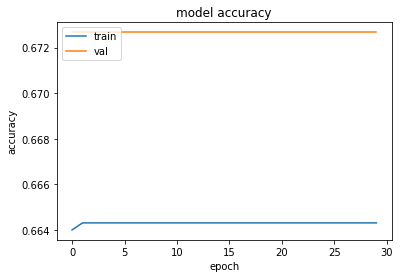

In [162]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Skip-gram

In [163]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():

    if word == 'PAD':
        continue

    try:
        weights[i] = sg_embeddings[word2id[word]]
    
    except KeyError:
        continue
        weights[i] = sg_embeddings[word2id['опрагпллирао']]

In [164]:
inputs = tf.keras.layers.Input(shape=(200,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [165]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6691 - accuracy: 0.6641 - val_loss: 0.6494 - val_accuracy: 0.6727
Epoch 2/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6444 - accuracy: 0.6643 - val_loss: 0.6347 - val_accuracy: 0.6727
Epoch 3/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6369 - accuracy: 0.6643 - val_loss: 0.6302 - val_accuracy: 0.6727
Epoch 4/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6348 - accuracy: 0.6643 - val_loss: 0.6285 - val_accuracy: 0.6727
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6338 - accuracy: 0.6643 - val_loss: 0.6276 - val_accuracy: 0.6727
Epoch 6/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6330 - accuracy: 0.6643 - val_loss: 0.6268 - val_accuracy: 0.6727
Epoch 7/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6323 - accuracy: 0.6643 - val_loss: 0.6261 - val_accuracy: 0.6727
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


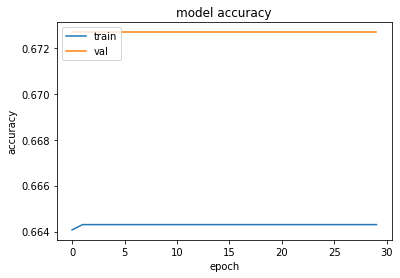

In [166]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Лучше всего себя показала модель Word2Vec.